In [ ]:
!pip install langfuse litellm --quiet --upgrade

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

# CrewAI Observability with Langfuse

[Langfuse](https://langfuse.com/) is an open-source observability and analytics platform designed specifically for LLM applications. Langfuse helps you track, monitor, and analyze your LLM application's performance, costs, and behavior.

With Langfuse, you can:

- Track and analyze LLM interactions and their associated costs
- Monitor model performance and latency
- Debug production issues with detailed tracing
- Evaluate output quality and model behavior
- Collect user feedback and ground truth data and more.

## Setup

We'll walk through creating a Langfuse account, setting up a project, generating API credentials, and configuring custom model definitions. This will prepare us to start tracing our LLM applications.

**Important**: for the sake of this workshop, we will not be creating a custom server running LangFuse, and will instead use the [SaaS version](https://cloud.langfuse.com/) of the product. If you want, you can learn how to host your own LangFuse server on [Langfuse doc](https://langfuse.com/self-hosting), or using this [GitHub repository](https://github.com/aws-samples/deploy-langfuse-on-ecs-with-fargate/).

1. Start by **creating your account on [LangFuse Cloud](https://cloud.langfuse.com/)**
1. Create a **New Organization** and enter an organization name, for example `AnyCompany`. Skip the Invite Members step.
1. Enter a **name** for the new project and click **Create**.
1. Note down the **Secret Key**, **Public Key** and **Host** on your computer. Note you can also find the credentials in the *Settings -> API Keys* page.
1. We will be using the `langfuse` SDK to achieve our goals of obtaining traces and logs for our agents.

## Tracing

Let's get to tracing. Start by installing the required libraries:

Set your Langfuse API keys and endpoint. In this sample we're just using the [simple Langfuse integration for LiteLLM](https://langfuse.com/docs/integrations/litellm/tracing), but there's also the option to use the OpenTelemetry standard for traces. More information [here](https://langfuse.com/docs/opentelemetry/get-started)

In [ ]:
import os
import litellm

LANGFUSE_SECRET_KEY=input("Enter your Langfuse Secret Key: ")
LANGFUSE_PUBLIC_KEY=input("Enter your Langfuse Public Key: ")

os.environ["LANGFUSE_SECRET_KEY"] = LANGFUSE_SECRET_KEY
os.environ["LANGFUSE_PUBLIC_KEY"] = LANGFUSE_PUBLIC_KEY
os.environ["LANGFUSE_HOST"]="https://us.cloud.langfuse.com" # US data region
#os.environ["LANGFUSE_HOST"]="https://cloud.langfuse.com" # EU data region

# Configure callbacks
litellm.success_callback = ["langfuse"]
litellm.failure_callback = ["langfuse"]


We will start with a very simple completion LLM call, befire jumpin into an autonomous agent execution.

In [ ]:
input_text = "What is the weather like in Bari, Italy?"
messages = [{
        "role": "user",
        "content": input_text
}]

response = litellm.completion(
   model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
   aws_region_name="us-west-2",
   messages=messages,
   max_tokens=4096,
   temperature=0.1,
)['choices'][0]['message']
print(response)

Now go to the project you've just created in Langfuse cloud, and you should be able to see a single trace got created:

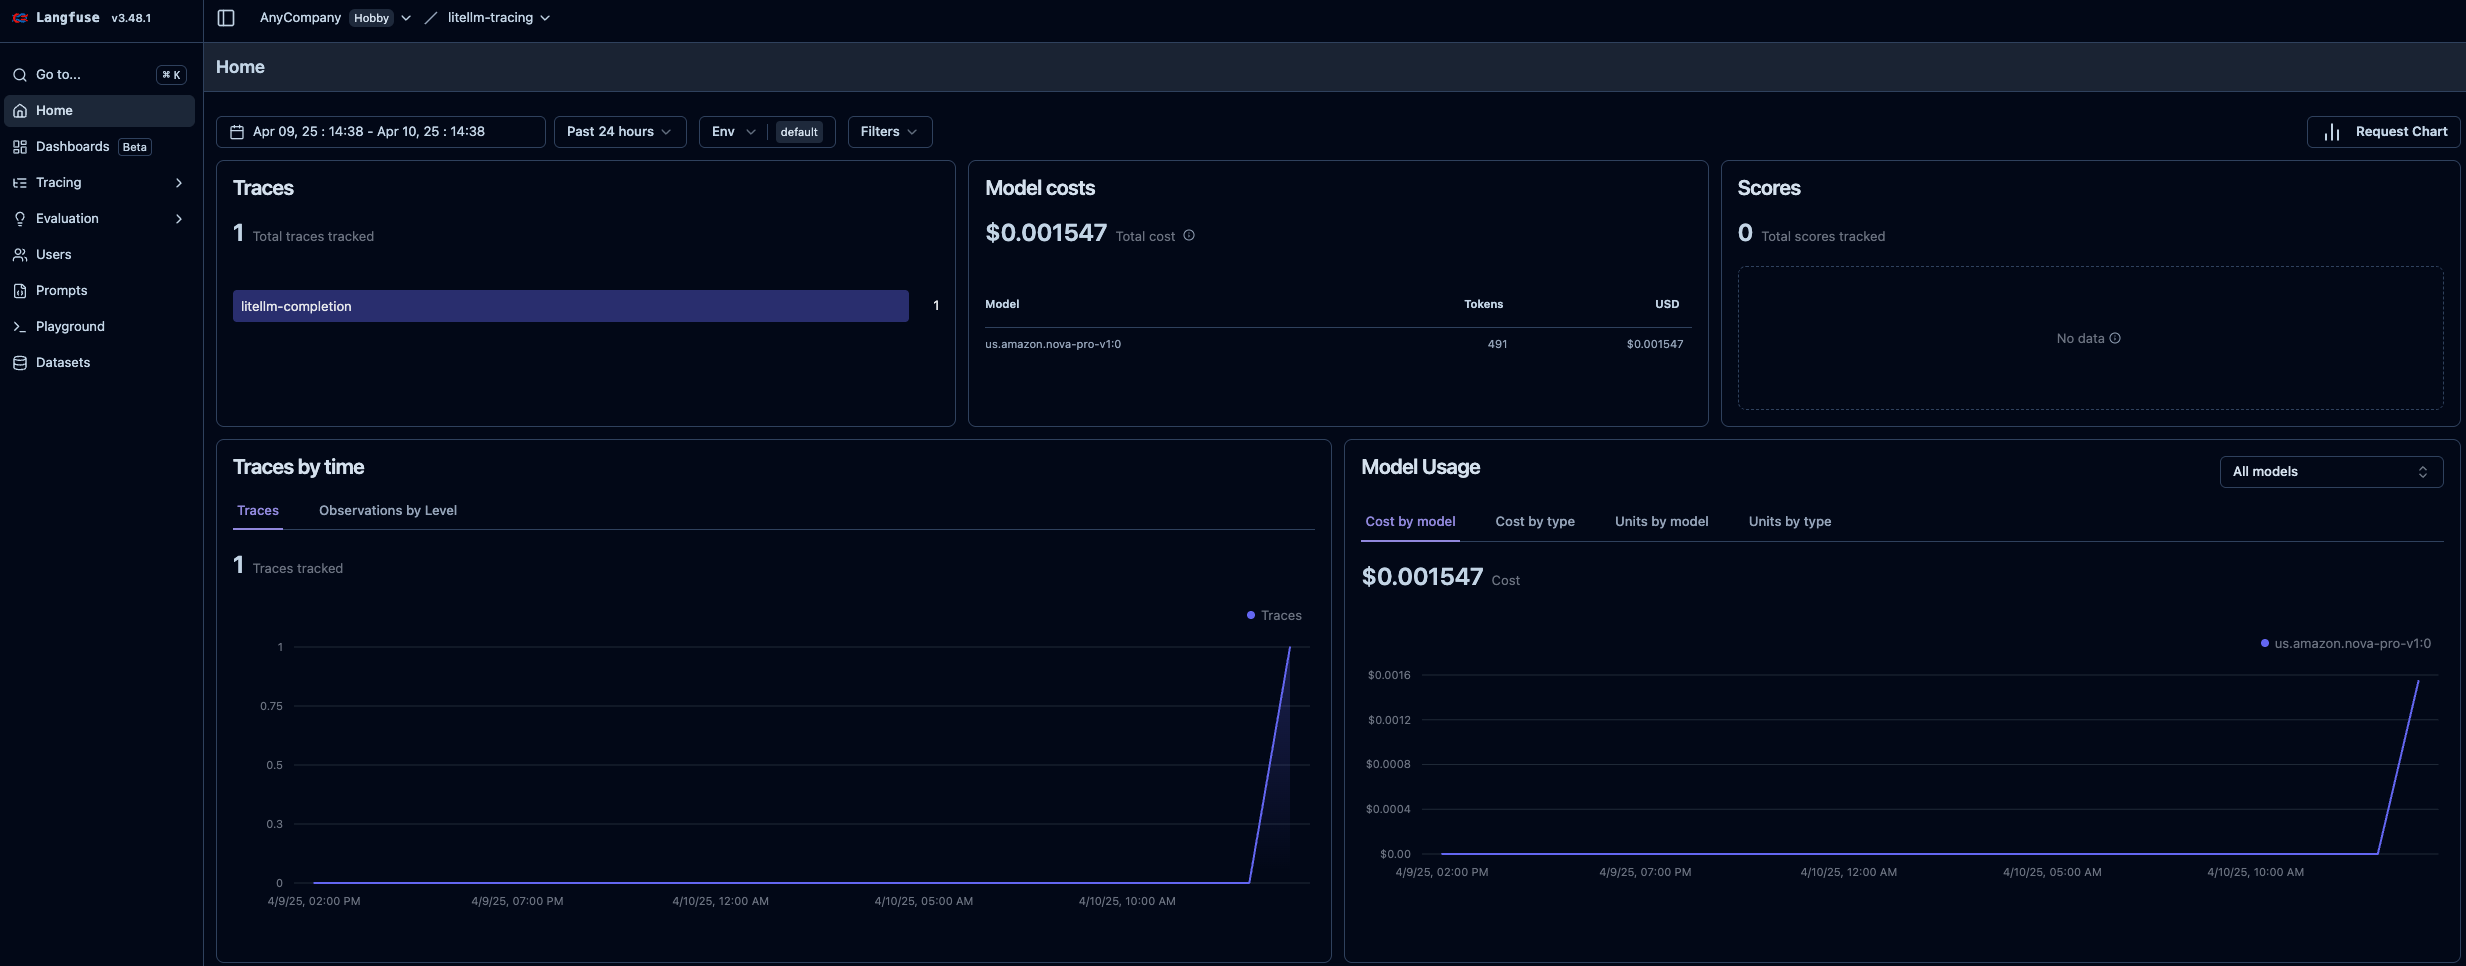

Let's try something more complicated:

In [ ]:
import json

def get_weather(city: str, country: str = "US") -> dict:
    """Get the current weather for a city."""
    # This is a mock implementation
    return {
        "city": city,
        "country": country,
        "temperature": 72,
        "conditions": "sunny"
    }
def translate_text(text: str, target_language: str) -> dict:
    """Translate text to the target language."""
    # This is a mock implementation
    return {
        "original": text,
        "translated": f"[{text} translated to {target_language}]",
        "target_language": target_language
    }

# Define the tools
tools = [
    # Weather tool
    ({
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get the current weather for a city",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {
                        "type": "string",
                        "description": "The name of the city"
                    },
                    "country": {
                        "type": "string",
                        "description": "The country code (default: US)",
                        "default": "US"
                    }
                },
                "required": ["city"]
            }
        }
    }, get_weather),
    
    # Translation tool
    ({
        "type": "function",
        "function": {
            "name": "translate_text",
            "description": "Translate text to another language",
            "parameters": {
                "type": "object",
                "properties": {
                    "text": {
                        "type": "string",
                        "description": "The text to translate"
                    },
                    "target_language": {
                        "type": "string",
                        "description": "The target language code (e.g., 'es' for Spanish)"
                    }
                },
                "required": ["text", "target_language"]
            }
        }
    }, translate_text)
]

In [ ]:
import json
import litellm
import uuid

class AutonomousAgent:
    def __init__(self, tools:list, model_id:str="bedrock/us.amazon.nova-pro-v1:0", max_tokens:int=5*1024, temperature:float=0.1):
        self.model_id = model_id
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.tools = tools
        self.messages = []
        self.trace_id = f"autonomous-agent-{uuid.uuid4().hex}"

    def converse(self, input_text:str):
        print(f"Conversation ID: {self.trace_id}\n")
        self.messages = [{
            "role": "user",
            "content": input_text
        }]
        print(f"{self.messages[-1]['role']}: {self.messages[-1]['content'].strip()}")

        response = litellm.completion(
            messages=self.messages,
            aws_region_name="us-west-2",
            model=self.model_id,
            max_tokens=self.max_tokens,
            temperature=self.temperature,
            tools=[x[0] for x in tools],
            metadata={"trace_id": self.trace_id}
        )['choices'][0]['message']
        self.messages.append(dict(response))
        print(f"{self.messages[-1]['role']}: {self.messages[-1]['content'].strip()}")

        # Loop until no more tool calls
        tool_call = True
        while tool_call is not None:
            tool_call = response.get('tool_calls', None)
            required_tool_name = tool_call[0].function.name
            required_tool_arguments = json.loads(tool_call[0].function.arguments)
            for tool_definition, tool_function in tools:
                if tool_definition['function']['name'] == required_tool_name:
                    tool_response = tool_function(**required_tool_arguments)
                    break
            self.messages.append({
                "tool_call_id": tool_call[0]['id'],
                "role": "tool",
                "name": required_tool_name,
                "content": json.dumps(tool_response)
            })
            response = litellm.completion(
                model=self.model_id, # Uncomment to use Amazon Bedrock
                aws_region_name="us-west-2",
                messages=self.messages,
                max_tokens=self.max_tokens,
                temperature=self.temperature,
                tools=[x[0] for x in tools],
                metadata={"existing_trace_id": self.trace_id},
            )['choices'][0]['message']
            self.messages.append(dict(response))
            print(f"{self.messages[-1]['role']}: {self.messages[-1]['content'].strip()}")

            tool_call = response.get('tool_calls', None)


agent = AutonomousAgent(tools)
agent.converse("What is the weather in Bari, Italy? Give me the answer in Italian")

In this example, we run an autonomous agents that has two (simulated) tools assigned to it. In the code, we assign every `completion` API call to the same Langfuce Trace ID. After that, we can see in Langfuse UI the total cost of the agent invocation, the total latency, as well as a timeline breakdown of the API calls that happened behind the scenes.

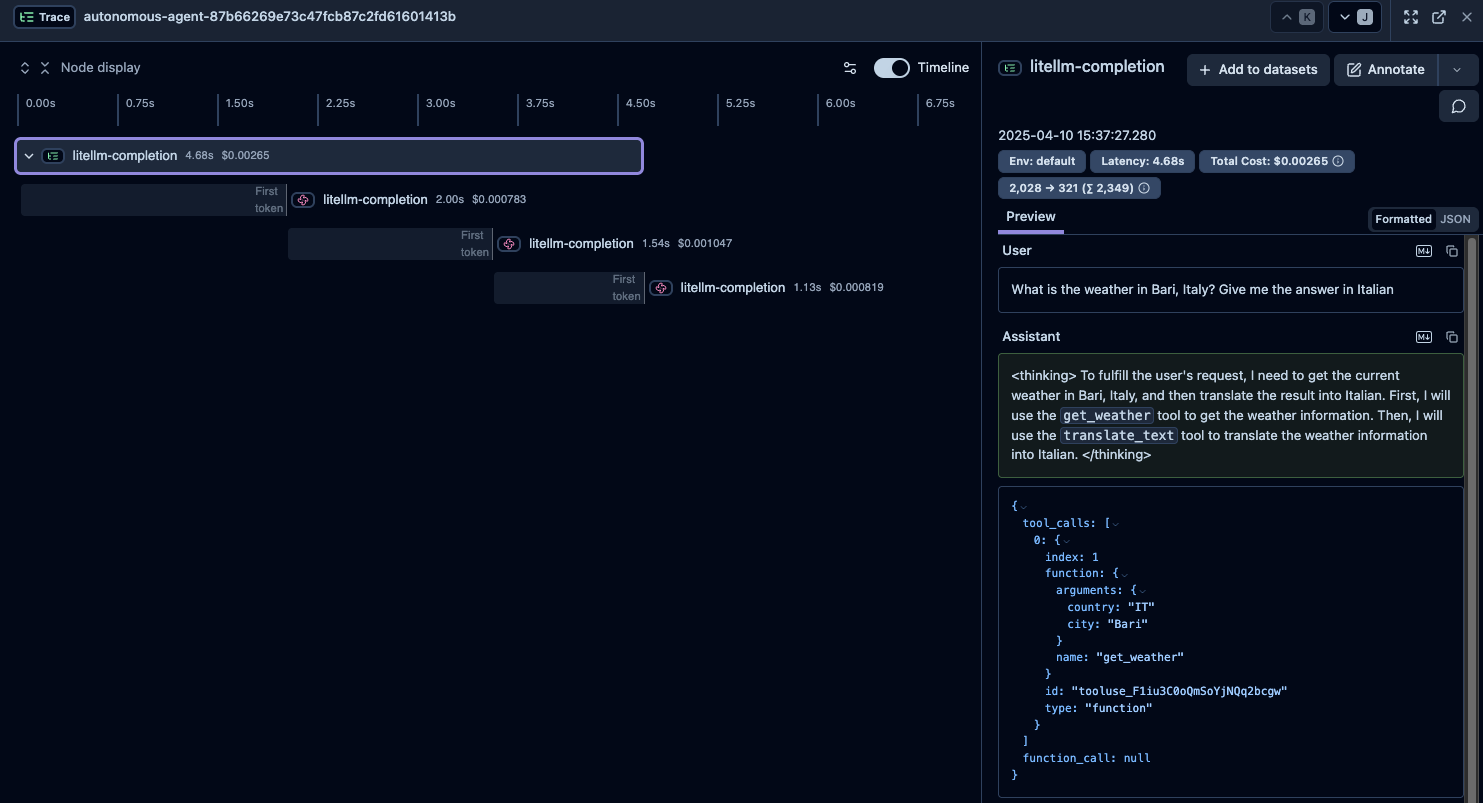